# Introduction : Balbutiements de la vérification du CPAM sur des stocks américains comparés au S&P 500.

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# ==========================================
# 1. CONFIGURATION ET TÉLÉCHARGEMENT
# ==========================================
# Choix des actifs : Tech (AAPL, TSLA), Conso (KO), Banque (JPM), Or (GLD)
assets = ["AAPL", "TSLA", "KO", "JPM", "GLD"]
market = "^GSPC" # S&P 500
tickers = [market] + assets

print("--- Téléchargement des données ---")
df = yf.download(tickers, start="2019-01-01", end="2025-01-01", auto_adjust=True)

# Fix pour la structure des colonnes (Multi-index)
if isinstance(df.columns, pd.MultiIndex):
    data = df.xs('Close', axis=1, level=0)
else:
    data = df

returns = data.pct_change().dropna()

--- Téléchargement des données ---


[*********************100%***********************]  6 of 6 completed


In [ ]:
# ==========================================
# 2. CALCUL DU CAPM (Période Globale)
# ==========================================
rf = 0.03  # Hypothèse de taux sans risque (3%)
market_ann_ret = returns[market].mean() * 252
market_var = returns[market].var()

results = []
for asset in assets:
    # Calcul Bêta
    beta = returns[asset].cov(returns[market]) / market_var
    # Rendement annuel réel
    actual_ret = returns[asset].mean() * 252
    # Rendement théorique (CAPM)
    expected_ret = rf + beta * (market_ann_ret - rf)
    # Alpha (Performance anormale)
    alpha = actual_ret - expected_ret

    results.append({
        'Asset': asset,
        'Beta': beta,
        'Actual_Ret': actual_ret,
        'Expected_Ret': expected_ret,
        'Alpha': alpha
    })

df_capm = pd.DataFrame(results)
print("\n--- Analyse CAPM Globale ---")
print(df_capm.round(3))


--- Analyse CAPM Globale ---
  Asset   Beta  Actual_Ret  Expected_Ret  Alpha
0  AAPL  1.199       0.364         0.189  0.175
1  TSLA  1.561       0.704         0.237  0.467
2    KO  0.608       0.099         0.111 -0.012
3   JPM  1.079       0.223         0.173  0.050
4   GLD  0.091       0.127         0.042  0.084


In [ ]:
# ==========================================
# 3. ANALYSE DE CRISE (Comparaison 2019 vs COVID 2020)
# ==========================================
def get_beta(df_returns, asset, market_ticker):
    return df_returns[asset].cov(df_returns[market_ticker]) / df_returns[market_ticker].var()

# Périodes
normal_period = returns.loc['2019-01-01':'2019-12-31']
crisis_period = returns.loc['2020-02-01':'2020-05-30']

print("\n--- Instabilité du Bêta (Normal vs Crise COVID) ---")
for asset in assets:
    b_norm = get_beta(normal_period, asset, market)
    b_cris = get_beta(crisis_period, asset, market)
    diff = ((b_cris / b_norm) - 1) * 100
    print(f"{asset} | Bêta Normal: {b_norm:.2f} | Bêta Crise: {b_cris:.2f} | Changement: {diff:+.1f}%")


--- Instabilité du Bêta (Normal vs Crise COVID) ---
AAPL | Bêta Normal: 1.56 | Bêta Crise: 1.06 | Changement: -32.1%
TSLA | Bêta Normal: 1.32 | Bêta Crise: 1.11 | Changement: -16.2%
KO | Bêta Normal: 0.45 | Bêta Crise: 0.80 | Changement: +78.1%
JPM | Bêta Normal: 1.06 | Bêta Crise: 1.32 | Changement: +24.6%
GLD | Bêta Normal: -0.25 | Bêta Crise: 0.08 | Changement: -132.7%


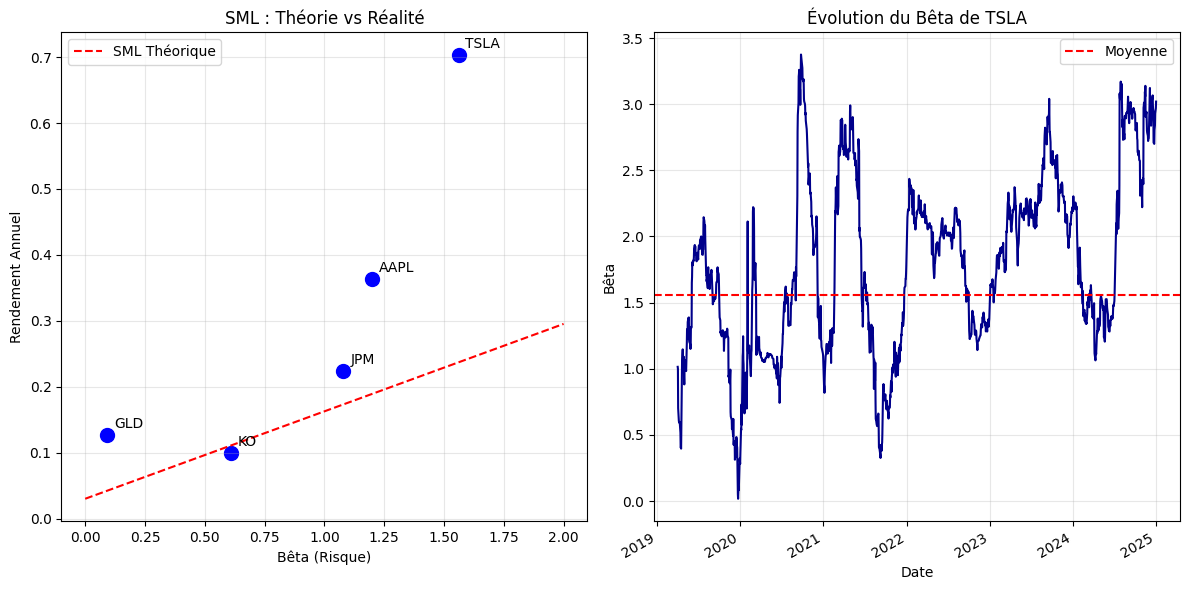

In [ ]:
# ==========================================
# 4. VISUALISATION
# ==========================================
plt.figure(figsize=(12, 6))

# Graphique 1 : Security Market Line (SML)
plt.subplot(1, 2, 1)
x_sml = np.linspace(0, 2, 10)
y_sml = rf + x_sml * (market_ann_ret - rf)
plt.plot(x_sml, y_sml, 'r--', label="SML Théorique")
plt.scatter(df_capm['Beta'], df_capm['Actual_Ret'], color='blue', s=100)

for i, txt in enumerate(df_capm['Asset']):
    plt.annotate(txt, (df_capm['Beta'][i], df_capm['Actual_Ret'][i]), xytext=(5,5), textcoords='offset points')

plt.title("SML : Théorie vs Réalité")
plt.xlabel("Bêta (Risque)")
plt.ylabel("Rendement Annuel")
plt.legend()
plt.grid(True, alpha=0.3)

# Graphique 2 : Bêta Roulant (Instabilité)
plt.subplot(1, 2, 2)
asset_to_plot = "TSLA"
rolling_window = 63 # 3 mois environ
rolling_beta = (returns[asset_to_plot].rolling(rolling_window).cov(returns[market]) /
                returns[market].rolling(rolling_window).var())
rolling_beta.plot(color='darkblue')
plt.axhline(df_capm.loc[df_capm['Asset']==asset_to_plot, 'Beta'].values[0], color='red', linestyle='--', label="Moyenne")
plt.title(f"Évolution du Bêta de {asset_to_plot}")
plt.xlabel("Date")
plt.ylabel("Bêta")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Partie 2 : L'amélioration de notre modèle, il faut un degré de preuve supplémentaire pour rejeter le CAPM.

In [ ]:
# ============================================================
# 0. LIBRAIRIES
# ============================================================
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.api import OLS, add_constant

plt.style.use("default")



In [ ]:
# ============================================================
# 1. CONFIGURATION & TÉLÉCHARGEMENT DES DONNÉES
# ============================================================

assets = [
    # Tech
    "AAPL","MSFT","NVDA","GOOGL","META","AMZN","ORCL","ADBE","CRM","INTC",
    # Finance
    "JPM","BAC","WFC","GS","MS","C","AXP","BLK",
    # Consommation
    "KO","PEP","WMT","COST","PG","MCD","NKE","HD",
    # Santé
    "JNJ","PFE","MRK","UNH","ABBV","TMO",
    # Industrie / énergie
    "XOM","CVX","CAT","BA","GE","MMM",
    # Telecom / divers
    "VZ","T","DIS","IBM"
]

market = "^GSPC"
tickers = [market] + assets

start_date = "2019-01-01"
end_date   = "2025-01-01"

rf_annual = 0.03
rf_daily = rf_annual / 252

print("Téléchargement des données...")
df = yf.download(tickers, start=start_date, end=end_date,
                 auto_adjust=True, progress=False)

prices = df.xs("Close", axis=1, level=0)
returns = prices.pct_change().dropna()


Téléchargement des données...


In [ ]:
# ============================================================
# 2. ESTIMATION CAPM INDIVIDUELLE (ALPHA / BETA)
# ============================================================

capm_results = []

for asset in assets:
    y = returns[asset] - rf_daily
    X = add_constant(returns[market] - rf_daily)

    model = OLS(y, X).fit()

    capm_results.append({
        "Asset": asset,
        "Alpha": model.params["const"] * 252,
        "t_alpha": model.tvalues["const"],
        "Beta": model.params[market],
        "R2": model.rsquared
    })

df_alpha = pd.DataFrame(capm_results)

print("\nRésumé des estimations CAPM individuelles :")
print(df_alpha.describe().round(3))



Résumé des estimations CAPM individuelles :
        Alpha  t_alpha    Beta      R2
count  42.000   42.000  42.000  42.000
mean    0.032    0.361   0.966   0.398
std     0.114    0.995   0.314   0.126
min    -0.230   -1.742   0.419   0.168
25%    -0.015   -0.171   0.710   0.322
50%     0.039    0.454   1.005   0.394
75%     0.086    0.927   1.198   0.497
max     0.482    3.156   1.791   0.674


In [ ]:

# ============================================================
# 3. TEST CENTRAL DU CAPM : CROSS-SECTION RENDEMENT–BÊTA
# ============================================================

# Rendement annuel moyen observé
mean_returns = returns[assets].mean() * 252

X_cs = add_constant(df_alpha["Beta"])
y_cs = mean_returns.values

cs_model = OLS(y_cs, X_cs).fit()

print("\nRégression cross-section (CAPM) :")
print(cs_model.summary())



Régression cross-section (CAPM) :
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     16.22
Date:                Tue, 10 Feb 2026   Prob (F-statistic):           0.000245
Time:                        14:03:22   Log-Likelihood:                 33.632
No. Observations:                  42   AIC:                            -63.26
Df Residuals:                      40   BIC:                            -59.79
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.

Le faible R² indique que le CAPM n’explique qu’une fraction limitée des différences de rendement entre actifs (29%).

Même lorsque la relation est statistiquement significative, la majorité de la variation des rendements reste inexpliquée.

Cela suggère que le modèle est trop simplifié pour capturer la complexité des marchés réels.

In [ ]:

# ============================================================
# 4. PORTEFEUILLES TRIÉS PAR BÊTA
# ============================================================

df_alpha["Beta_Q"] = pd.qcut(df_alpha["Beta"], 5, labels=False)

portfolio_returns = []

for q in range(5):
    assets_q = df_alpha[df_alpha["Beta_Q"] == q]["Asset"]
    ret_q = returns[assets_q].mean(axis=1).mean() * 252
    portfolio_returns.append(ret_q)

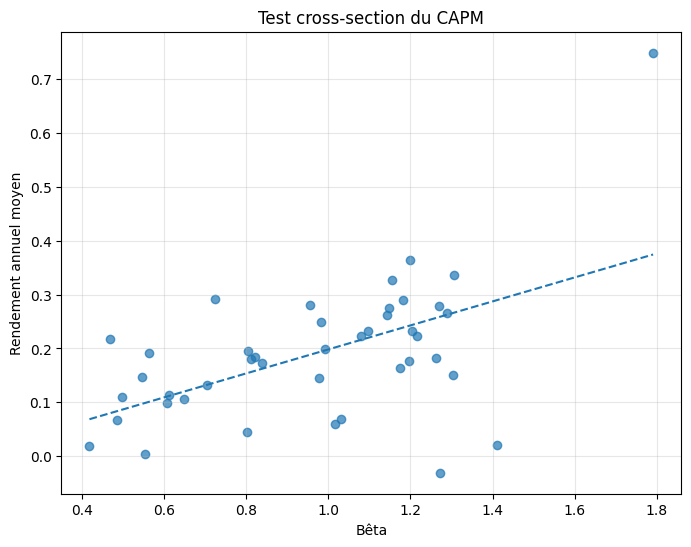

In [ ]:

# ============================================================
# 5. VISUALISATIONS (ORDRE LOGIQUE POUR L’ORAL)
# ============================================================

# ------------------------------------------------------------
# Graphique 1 — Cross-section rendement vs bêta
# ------------------------------------------------------------
plt.figure(figsize=(8,6))
plt.scatter(df_alpha["Beta"], mean_returns, alpha=0.7)

x = np.linspace(df_alpha["Beta"].min(), df_alpha["Beta"].max(), 100)
y = cs_model.params["const"] + cs_model.params["Beta"] * x
plt.plot(x, y, linestyle="--")

plt.xlabel("Bêta")
plt.ylabel("Rendement annuel moyen")
plt.title("Test cross-section du CAPM")
plt.grid(True, alpha=0.3)
plt.show()


La relation entre bêta et rendement moyen est globalement positive, mais très dispersée.

Plusieurs actifs à bêta similaire affichent des rendements très différents.

Cela indique que le bêta n’explique qu’imparfaitement la cross-section des rendements, inversement à la prédiction centrale du CAPM.

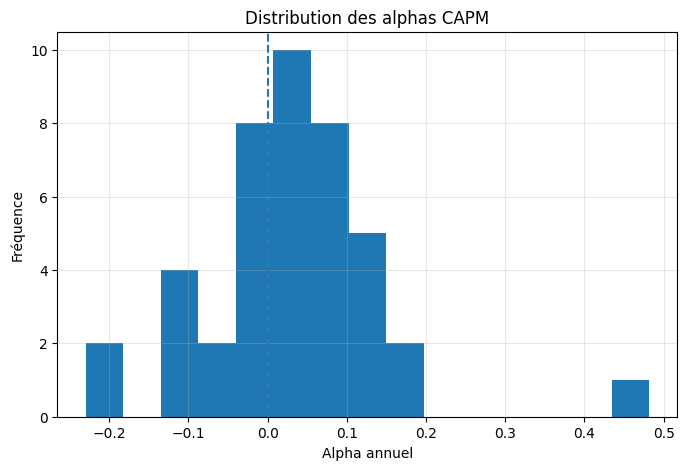

In [ ]:
# ------------------------------------------------------------
# Graphique 2 — Distribution des alphas
# ------------------------------------------------------------
plt.figure(figsize=(8,5))
plt.hist(df_alpha["Alpha"], bins=15)
plt.axvline(0, linestyle="--")

plt.xlabel("Alpha annuel")
plt.ylabel("Fréquence")
plt.title("Distribution des alphas CAPM")
plt.grid(True, alpha=0.3)
plt.show()

La distribution des alphas est large et clairement non concentrée autour de zéro.

Plusieurs actifs présentent des alphas positifs ou négatifs économiquement importants.

Cela suggère que les écarts au CAPM sont structurels et non dus uniquement au bruit statistique.

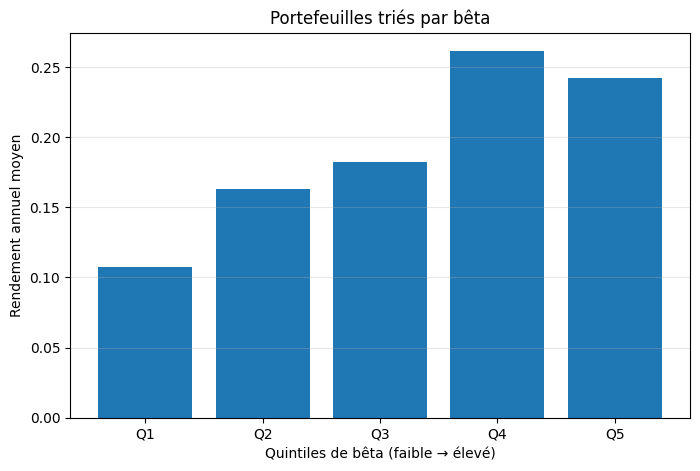

In [ ]:
# ------------------------------------------------------------
# Graphique 3 — Rendement des portefeuilles par quintile de bêta
# ------------------------------------------------------------
plt.figure(figsize=(8,5))
plt.bar([f"Q{i+1}" for i in range(5)], portfolio_returns)

plt.xlabel("Quintiles de bêta (faible → élevé)")
plt.ylabel("Rendement annuel moyen")
plt.title("Portefeuilles triés par bêta")
plt.grid(True, axis="y", alpha=0.3)
plt.show()


Les rendements moyens augmentent globalement avec le bêta, mais la relation n’est pas strictement monotone.

Le portefeuille à bêta le plus élevé ne surperforme pas systématiquement le quintile précédent.

Ainsi, le bêta ne permet pas de classer parfaitement les actifs selon leur rendement espéré.

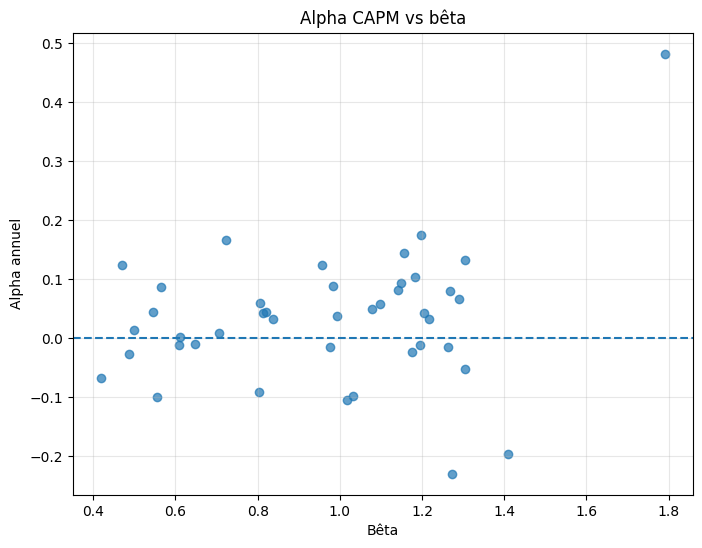

In [ ]:

# ------------------------------------------------------------
# Graphique 4 — Alpha en fonction du bêta
# ------------------------------------------------------------
plt.figure(figsize=(8,6))
plt.scatter(df_alpha["Beta"], df_alpha["Alpha"], alpha=0.7)
plt.axhline(0, linestyle="--")

plt.xlabel("Bêta")
plt.ylabel("Alpha annuel")
plt.title("Alpha CAPM vs bêta")
plt.grid(True, alpha=0.3)
plt.show()

Les alphas sont dispersés autour de zéro pour tous les niveaux de bêta, sans relation claire.

Des alphas importants apparaissent aussi bien pour des bêta faibles que élevés.

Cela indique que les erreurs du CAPM ne sont pas liées au risque de marché, mais à des facteurs omis.

# Conclusion intermédiaire

Même en utilisant beaucoup d’actions très liquides, le CAPM n’explique qu’une partie des différences de rendement.

Le bêta joue un rôle, mais il ne suffit pas : des actifs avec un risque similaire ont des performances très différentes.

Cela montre que le risque de marché seul ne capture pas toute la réalité des rendements observés

# Partie 3 --> Un défaut spécifique au marché US ou structurel ? Le test sur les marchés Européens.

In [ ]:
# ============================================================
# 0. LIBRAIRIES
# ============================================================
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.api import OLS, add_constant

plt.style.use("default")



In [ ]:
# ============================================================
# 1. CONFIGURATION & DONNÉES — EURO STOXX 600
# ============================================================

assets_eu = [
    # France
    "AIR.PA","MC.PA","OR.PA","BNP.PA","SAN.PA","SU.PA","DG.PA",
    # Allemagne
    "SAP.DE","SIE.DE","ALV.DE","BAS.DE","BMW.DE","ADS.DE","VOW3.DE",
    # Suisse
    "NESN.SW","NOVN.SW","ROG.SW",
    # UK
    "ULVR.L","HSBA.L","BP.L","AZN.L","RIO.L",
    # Pays-Bas
    "ASML.AS","INGA.AS","PHIA.AS",
    # Espagne
    "IBE.MC","ITX.MC","SAN.MC",
    # Italie
    "ENEL.MI","ENI.MI",
    # Nordiques
    "NOVO-B.CO","DSV.CO",
    # Divers
    "CS.PA","ABBN.SW","KER.PA","STLAM.MI"
]

market_eu = "^STOXX"  # STOXX Europe 600
tickers = [market_eu] + assets_eu

start_date = "2019-01-01"
end_date   = "2025-01-01"

rf_annual = 0.03
rf_daily = rf_annual / 252

print("Téléchargement des données Europe...")
df = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    auto_adjust=True,
    progress=False
)

prices = df.xs("Close", axis=1, level=0)
returns = prices.pct_change().dropna()



Téléchargement des données Europe...


/tmp/ipython-input-1931922753.py:45: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna()


In [ ]:

# ============================================================
# 2. ESTIMATION CAPM INDIVIDUELLE (ALPHA / BETA)
# ============================================================

capm_results_eu = []

for asset in assets_eu:
    Y = returns[asset] - rf_daily
    X = add_constant(returns[market_eu] - rf_daily)

    model = OLS(Y, X).fit()

    capm_results_eu.append({
        "Asset": asset,
        "Alpha": model.params["const"] * 252,
        "t_alpha": model.tvalues["const"],
        "Beta": model.params[market_eu],
        "R2": model.rsquared
    })

df_alpha_eu = pd.DataFrame(capm_results_eu)

print("\nRésumé CAPM — Europe :")
print(df_alpha_eu.describe().round(3))



Résumé CAPM — Europe :
        Alpha  t_alpha    Beta      R2
count  36.000   36.000  36.000  36.000
mean    0.058    0.689   1.063   0.392
std     0.080    0.914   0.338   0.148
min    -0.099   -1.020   0.382   0.100
25%     0.005    0.059   0.901   0.290
50%     0.054    0.636   1.155   0.431
75%     0.103    1.384   1.303   0.486
max     0.241    2.837   1.565   0.614


In [ ]:
# ============================================================
# 3. TEST CENTRAL DU CAPM — CROSS-SECTION RENDEMENT–BÊTA
# ============================================================

mean_returns_eu = returns[assets_eu].mean() * 252

X_cs = add_constant(df_alpha_eu["Beta"])
y_cs = mean_returns_eu.values

cs_model_eu = OLS(y_cs, X_cs).fit()

print("\nRégression cross-section CAPM — Europe :")
print(cs_model_eu.summary())


Régression cross-section CAPM — Europe :
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     3.193
Date:                Tue, 10 Feb 2026   Prob (F-statistic):             0.0829
Time:                        14:03:30   Log-Likelihood:                 40.353
No. Observations:                  36   AIC:                            -76.71
Df Residuals:                      34   BIC:                            -73.54
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

Le bêta est bien positivement lié au rendement moyen, ce qui va dans le sens du CAPM.

Cependant, cette relation est faible en Europe et seulement partielle aux États-Unis.

Le risque de marché est donc rémunéré, mais il ne constitue pas l’unique déterminant des rendements.

In [ ]:
# ============================================================
# 4. PORTEFEUILLES TRIÉS PAR BÊTA
# ============================================================

df_alpha_eu["Beta_Q"] = pd.qcut(df_alpha_eu["Beta"], 5, labels=False)

portfolio_returns_eu = []

for q in range(5):
    assets_q = df_alpha_eu[df_alpha_eu["Beta_Q"] == q]["Asset"]
    ret_q = returns[assets_q].mean(axis=1).mean() * 252
    portfolio_returns_eu.append(ret_q)

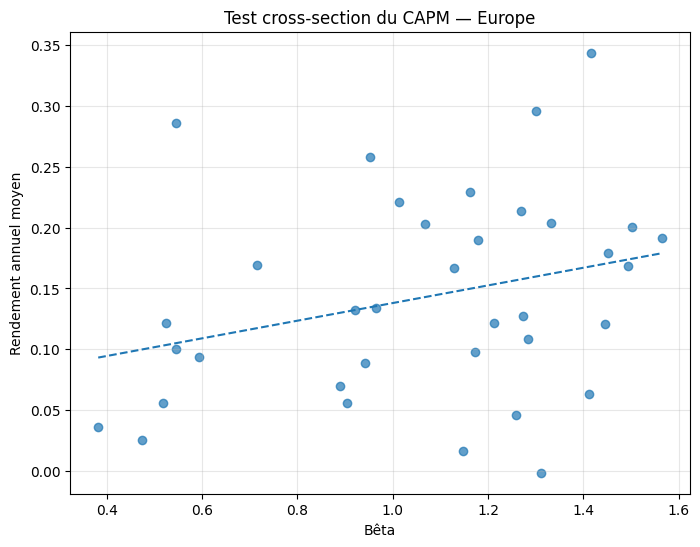

In [ ]:
# ============================================================
# 5. VISUALISATIONS — MÊME ORDRE QUE LA PARTIE US
# ============================================================

# ------------------------------------------------------------
# Graphique 1 — Cross-section rendement vs bêta
# ------------------------------------------------------------
plt.figure(figsize=(8,6))
plt.scatter(df_alpha_eu["Beta"], mean_returns_eu, alpha=0.7)

x = np.linspace(df_alpha_eu["Beta"].min(), df_alpha_eu["Beta"].max(), 100)
y = cs_model_eu.params["const"] + cs_model_eu.params["Beta"] * x
plt.plot(x, y, linestyle="--")

plt.xlabel("Bêta")
plt.ylabel("Rendement annuel moyen")
plt.title("Test cross-section du CAPM — Europe")
plt.grid(True, alpha=0.3)
plt.show()


La relation entre le bêta et le rendement annuel moyen est positive mais faible et très dispersée.

Des actifs ayant des niveaux de risque similaires affichent des rendements très différents.

Comme pour le marché américain, le bêta n’explique qu’imparfaitement la structure des rendements en Europe.

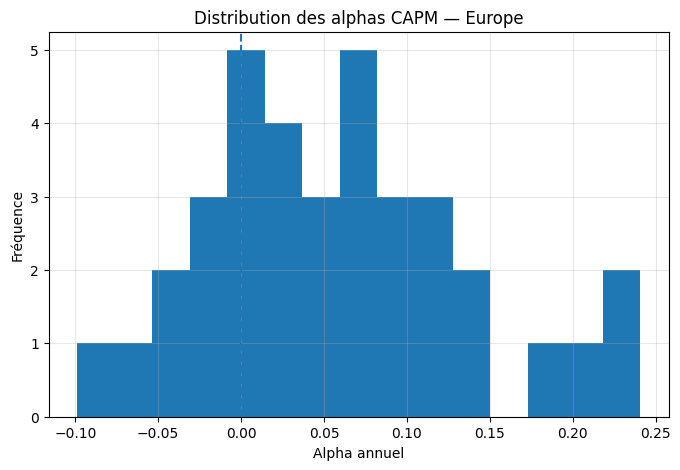

In [ ]:
# ------------------------------------------------------------
# Graphique 2 — Distribution des alphas
# ------------------------------------------------------------
plt.figure(figsize=(8,5))
plt.hist(df_alpha_eu["Alpha"], bins=15)
plt.axvline(0, linestyle="--")

plt.xlabel("Alpha annuel")
plt.ylabel("Fréquence")
plt.title("Distribution des alphas CAPM — Europe")
plt.grid(True, alpha=0.3)
plt.show()

La distribution des alphas est large et ne se concentre pas autour de zéro.

Plusieurs actifs présentent des alphas économiquement significatifs, positifs comme négatifs.

Cela suggère que les écarts au CAPM sont persistants et ne peuvent pas être attribués uniquement au bruit statistique.

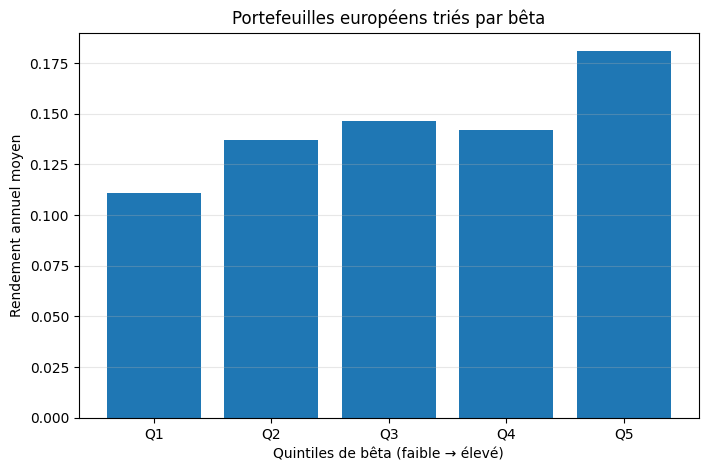

In [ ]:

# ------------------------------------------------------------
# Graphique 3 — Portefeuilles triés par bêta
# ------------------------------------------------------------
plt.figure(figsize=(8,5))
plt.bar([f"Q{i+1}" for i in range(5)], portfolio_returns_eu)

plt.xlabel("Quintiles de bêta (faible → élevé)")
plt.ylabel("Rendement annuel moyen")
plt.title("Portefeuilles européens triés par bêta")
plt.grid(True, axis="y", alpha=0.3)
plt.show()


Les rendements moyens augmentent globalement avec le bêta, mais la relation n’est pas strictement monotone.

Certains portefeuilles à bêta intermédiaire offrent des performances comparables, voire supérieures, aux portefeuilles plus risqués.

Ainsi, le bêta ne permet pas de classer de manière fiable les rendements attendus.

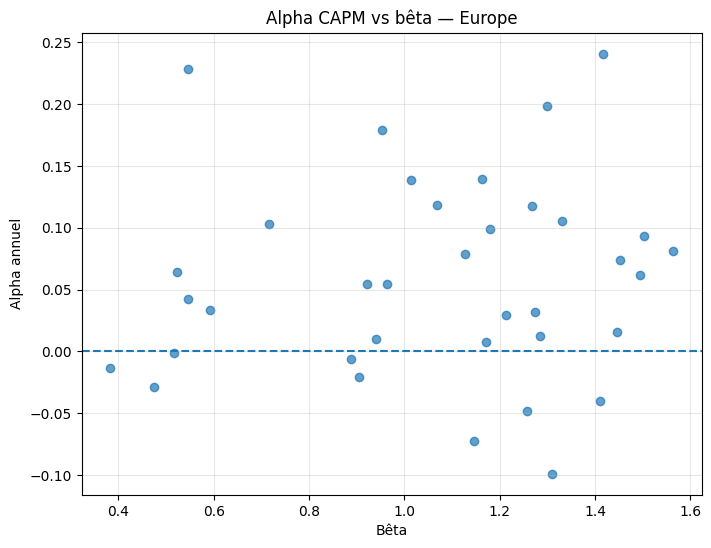

In [ ]:
# ------------------------------------------------------------
# Graphique 4 — Alpha en fonction du bêta
# ------------------------------------------------------------
plt.figure(figsize=(8,6))
plt.scatter(df_alpha_eu["Beta"], df_alpha_eu["Alpha"], alpha=0.7)
plt.axhline(0, linestyle="--")

plt.xlabel("Bêta")
plt.ylabel("Alpha annuel")
plt.title("Alpha CAPM vs bêta — Europe")
plt.grid(True, alpha=0.3)
plt.show()

Les alphas sont dispersés autour de zéro pour l’ensemble des niveaux de bêta, sans relation claire.

Des alphas importants apparaissent aussi bien pour des actifs peu risqués que très risqués.

Cela indique que les erreurs du CAPM ne sont pas liées au risque de marché, mais à des facteurs omis par le modèle.

#Conclusion générale

Les résultats empiriques obtenus sur les marchés américain et européen montrent que le CAPM capture une partie du risque moyen, mais qu’il échoue à expliquer pleinement la structure des rendements observés.

La relation entre le bêta et les rendements est faible et instable, et des alphas persistants subsistent malgré l’utilisation d’un univers large et liquide.

Ces constats suggèrent que les limites du CAPM ne sont ni dues à un manque de données, ni spécifiques à une zone géographique, mais reflètent une insuffisance structurelle du modèle.

# Pourquoi le CAPM s’écarte de la réalité empirique

Le CAPM repose sur des hypothèses fortes qui sont difficilement vérifiées dans la pratique.

Il suppose notamment que le risque pertinent est uniquement le risque de marché, que les investisseurs sont parfaitement diversifiés et qu’ils ont des anticipations homogènes.

En réalité, les actifs sont exposés à plusieurs sources de risque systématique qui ne sont pas capturées par un seul facteur de marché, ce qui conduit à des écarts persistants entre le modèle et les données observées.

#Ce que le CAPM ne prend pas en compte

Le CAPM ignore plusieurs dimensions empiriquement importantes, telles que la taille des entreprises, leur valorisation relative, leur dynamique de performance ou encore leur exposition à des risques macroéconomiques spécifiques.

Il ne tient pas non plus compte de frictions de marché comme les coûts de transaction, les contraintes de financement ou l’hétérogénéité des comportements des investisseurs.

Ces éléments contribuent à expliquer pourquoi des actifs peuvent présenter des rendements durablement différents de ceux prédits par le CAPM.

# Ouverture : vers des modèles plus granulaires

Pour mieux expliquer les rendements observés, la littérature empirique s’est orientée vers des modèles multifactoriels qui intègrent plusieurs sources de risque.

Des approches comme les modèles de Fama-French, les modèles à facteurs macroéconomiques ou les modèles conditionnels permettent d’améliorer significativement le pouvoir explicatif par rapport au CAPM.

Ces modèles offrent une description plus fine de la réalité des marchés, au prix toutefois d’une complexité accrue et d’un risque plus élevé de sur-ajustement.